# Step-size robustness experiments

We will try a simple experiment on a one-dimensional Gaussian to see if the step-size robustness property can be easily illustrated.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# specific functions
import HMC as h
from k_energies import *
import MC_diag as diag

In [2]:
# function to suppress output
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [3]:
# create potential class
class MiddleTail:
    def value(self, x):
        return np.abs(x) ** 1.5
    
    def grad(self, x):
        return 1.5 * x * np.abs(x) ** (0.5)
    
# quick checks
U = MiddleTail()
print U.value(0.5)
print U.grad(0.5)

0.353553390593
0.53033008589


In [4]:
# Set up ESJD experiment
U = MiddleTail()

K_g = Gauss()
#K_r = Laplace()
K_r = GR_family(1.0)
K_e = GR_family(1.5)
# ideally we want a p(1 - ln(p) kinetic energy, which we could sample from using adaptive rejection sampling.

n_samples = 40000
x_start = 0.5

stepsizes = np.linspace(start = 0.1, stop = 2.5, num = 20)
ESJDstore_g = np.zeros(len(stepsizes))
ESJDstore_r = np.zeros(len(stepsizes))
ESJDstore_e = np.zeros(len(stepsizes))

for i in xrange(len(stepsizes)):
    with suppress_stdout():
        neg_r = h.HMC(n_samples, x_start, U, K_r, L = 5, e = stepsizes[i], BurnIn = 0);
        neg_g = h.HMC(n_samples, x_start, U, K_g, L = 5, e = stepsizes[i], BurnIn = 0);
        neg_e = h.HMC(n_samples, x_start, U, K_e, L = 5, e = stepsizes[i], BurnIn = 0);
        
        samples_r = neg_r['x']
        samples_g = neg_g['x']
        samples_e = neg_e['x']
        
        ESJD_g = np.mean( (samples_g[0,1:(n_samples+1)] - samples_g[0,0:n_samples]) ** 2)
        ESJD_r = np.mean( (samples_r[0,1:(n_samples+1)] - samples_r[0,0:n_samples]) ** 2)
        ESJD_e = np.mean( (samples_e[0,1:(n_samples+1)] - samples_e[0,0:n_samples]) ** 2)
    
        ESJDstore_g[i] = ESJD_g
        ESJDstore_r[i] = ESJD_r
        ESJDstore_e[i] = ESJD_e
    print "Iteration:", i+1
    

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20


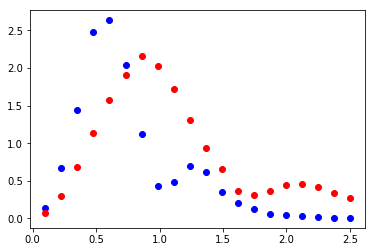

In [5]:
#print diag.ess(samples_r[0,:])
#print diag.ess(samples_g[0,:])

#print samples_g

#axes = plt.gca()
#axes.set_ylim([-6,6])

plt.plot(stepsizes, ESJDstore_g, 'bo');
#plt.plot(stepsizes, ESJDstore_e, 'go');
plt.plot(stepsizes, ESJDstore_r, 'ro');

This does seem to broadly correlate with the logic, although the kink in the Gaussian case around the values at which it is close to the period length is an annoyance.  We can define a randomized HMC kernel to get around this.

In [6]:
# New randomized HMC kernel
def RHMC(nits, x_input, U, K, L, e, BurnIn = 0, Random = False, MH = True):

    # preamble
    #if type(x_input) is float or type(x_input) is int:
    #    n = 1
    #else:
    #    n = len(x_input)

    x = x_input # initial value for x
    n = len(np.atleast_1d(x))
    accepted = 0.
    divergences = 0
    LeapFrogSteps = L # initialise numer of LeapFrogSteps
    x_store = np.empty((n,nits))
    p_store = np.empty((n,nits))


    for i in xrange(nits): # don't forget python arrays start at zero
        # propose
        p = K.sample(n) # resample momentum from (e^(-K(p))
        #if Random == True: # randomise LeapFrogSteps
        LeapFrogSteps = np.random.randint(1,2*L)
        cand = h.flow(x, p, U.grad, K.grad, LeapFrogSteps, e) # run dynamics
        x_can = cand[0,:]
        p_can = cand[1,:]

        # accept-reject if MH = True (otherwise accept all points)
        if MH == True:
            delta_H = U.value(x) + K.value(p) - U.value(x_can) - K.value(p_can)
            if delta_H < -1000:
                divergences += 1 # count numerical divergences
                # update chain
            u = np.random.uniform(0,1)
            if log(u) < delta_H:
                x = x_can
                p = p_can
                accepted += 1
        else:
            x = x_can
            p = p_can

        x_store[:,i] = x
        p_store[:,i] = p

        # Adapt step-size if BurnIn is nonzero
        if i <= BurnIn - 1 and (i+1) % 100 == 0:
            accept_rate = accepted / 100.0
            if accept_rate > 0.8:
                e = e * 1.1
            elif accept_rate < 0.6:
                e = e * 0.9
            accepted = 0

    # print acceptance rate
    accept_rate = accepted/float(nits - BurnIn)
    print "Acceptance rate: %f" % accept_rate
    print "LF Steps: %d, Step-size: %.3f" % (L,e)
    print "Numerical divergences: %d" % divergences

    # bind initial values with MCMC output
    x_return = np.empty((n, nits + 1))
    p_return = np.empty((n, nits + 1))
    x_return[:,0] = x_input
    x_return[:,1:] = x_store
    p_return[:,0] = np.zeros(n)
    p_return[:,1:] = p_store

    return { 'x':x_return, 'p':p_return }


In [7]:
RHMC(n_samples, x_start, U, K_g, L = 5, e = 1.0, BurnIn = 0);

Acceptance rate: 0.760575
LF Steps: 5, Step-size: 1.000
Numerical divergences: 0


In [8]:
# Set up ESJD experiment
U = MiddleTail()

K_g = Gauss()
#K_r = Laplace()
K_r = GR_family(1.0)
K_e = GR_family(1.5)
# ideally we want a p(1 - ln(p) kinetic energy, which we could sample from using adaptive rejection sampling.

n_samples = 200000
x_start = 0.5

stepsizes = np.linspace(start = 0.1, stop = 5.0, num = 80)
ESJDstore_g = np.zeros(len(stepsizes))
ESJDstore_r = np.zeros(len(stepsizes))
ESJDstore_e = np.zeros(len(stepsizes))

for i in xrange(len(stepsizes)):
    with suppress_stdout():
        neg_r = RHMC(n_samples, x_start, U, K_r, L = 5, e = stepsizes[i], BurnIn = 0);
        neg_g = RHMC(n_samples, x_start, U, K_g, L = 5, e = stepsizes[i], BurnIn = 0);
        neg_e = RHMC(n_samples, x_start, U, K_e, L = 5, e = stepsizes[i], BurnIn = 0);
        
        samples_r = neg_r['x']
        samples_g = neg_g['x']
        samples_e = neg_e['x']
        
        ESJD_g = np.mean( (samples_g[0,1:(n_samples+1)] - samples_g[0,0:n_samples]) ** 2)
        ESJD_r = np.mean( (samples_r[0,1:(n_samples+1)] - samples_r[0,0:n_samples]) ** 2)
        ESJD_e = np.mean( (samples_e[0,1:(n_samples+1)] - samples_e[0,0:n_samples]) ** 2)
    
        ESJDstore_g[i] = ESJD_g
        ESJDstore_r[i] = ESJD_r
        ESJDstore_e[i] = ESJD_e
    print "Iteration:", i+1
    

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
I

Text(0,0.5,u'ESJD')

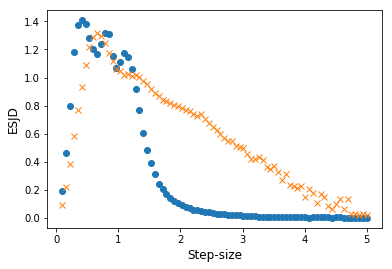

In [11]:

plt.plot(stepsizes, ESJDstore_g, 'o');
#plt.plot(stepsizes, ESJDstore_e, 'go');
plt.plot(stepsizes, ESJDstore_r, 'x');
#plt.plot(stepsizes, ESJDstore_e)
plt.xlabel('Step-size', fontsize=12)
plt.ylabel('ESJD', fontsize=12)

In [16]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
ax.plot(stepsizes, ESJDstore_g, 'o');
ax.plot(stepsizes, ESJDstore_r, 'x');
plt.xlabel('Step-size', fontsize=12)
plt.ylabel('ESJD', fontsize=12)
fig.savefig('step_robust.eps')   # save the figure to file
plt.close(fig)    # close the figure